**Criado por Erick De Rossi Faria**

**[Desafio Frexco 2023] 📈Previsão de demanda**

**Janeiro de 2023**

# <center> [Desafio Frexco 2023] 📈Previsão de demanda </center>

# Tabela de tópicos
<a id="toc"></a>
- [1. Introdução](#1)
- [2. Importações](#2)
- [3. Carregando e preparando dados](#3)
- [4. Modelos](#4)
    - .[4.1 Modelo ajustado sem auto-sarima](#4.1)
    - .[4.1 Modelo ajustado com auto-sarima](#4.2)
    - .[4.1 Modelo ajustado de forma própria](#4.3)
- [5. Métricas/escolha e Previsões pedidas](#5)

<a id="1"></a>
# **<center><span style="color:#386E6B;">1. Introdução  </span></center>**

<center><img src="https://empresas.frexco.com.br/og.png?050220" style="width: 800px; heigth: 350px"></center>


**Esse é um desafio proposto pela `Frexco` para vaga de estágio em data analytics.**

**_O desafio é o seguinte:_**

Previsão de demanda é uma projeção realizada com o intuito de prever o potencial de vendas de um ou mais produtos em um cenário futuro. 

Com base em dados e informações, numéricas e intencionais, o objetivo da previsão é aproximar ao máximo a perspectiva da realidade. Embora não seja possível determinar as ações do futuro, a estimativa permite guiar a tomada de decisão e elaborar um planejamento mais estratégico, voltado para as possibilidades reais do negócio.

Nos diversos setores, a previsão de demanda serve de amparo para nortear e orientar as ações mais importantes.

Nós, da Frexco, trabalhamos com produtos perecíveis e muitos deles possuem uma data de validade curta. Acertar na previsão de demanda é essencial para evitarmos o desperdício de alimentos, além de também ser importante garantir que tenhamos o produto disponível no estoque para venda.

Tendo isso em mente, estruture um script no Python que calcule a previsão de demanda para os próximos 5 dias do item, baseando-se no histórico presente na base de dados em anexo.

Obs: O modelo de previsão pode ser o que você julgue ser o melhor, mas atenção aos detalhes de variação nas vendas!.

<a href="#toc" role="button" aria-pressed="true" >⬆️De volta aos tópicos ⬆️</a>

<a id="2"></a>
# **<center><span style="color:#386E6B;">2. Importações  </span></center>**

In [1]:
#importando bibliotecas
## Numpy
import numpy as np

##Pandas
import pandas as pd

##Matplotlib
import matplotlib.pyplot as plt

##Statsmodels
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

#Pmdarima
from pmdarima import auto_arima

In [2]:
#importando o conjunto de dados
path_file = r'C:\Users\X\Downloads\Projetos\DesafioFrexco\Dados.xlsx'#caminho dos dados
dados = pd.read_excel(path_file)
dados.head() #conferindo a importação

,Data,Vendas
0,2022-12-06,870
1,2022-12-07,868
2,2022-12-08,1189
3,2022-12-09,742
4,2022-12-10,317


<a href="#toc" role="button" aria-pressed="true" >⬆️De volta aos tópicos ⬆️</a>

<a id="3"></a>
# **<center><span style="color:#386E6B;">3. Carregando e preparando dataset  </span></center>**

In [3]:
#conferindo os tipos de variáveis e informações superficiais
dados.info()
print(dados['Data'].max())
print(dados['Data'].min())
dados.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    46 non-null     datetime64[ns]
 1   Vendas  46 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 864.0 bytes
2023-01-20 00:00:00
2022-12-06 00:00:00


,Vendas
count,46.000000
mean,755.434783
std,430.762201
min,18.000000
25%,346.500000
50%,810.500000
75%,1053.750000
max,1692.000000


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Observações sobre as variáveis :</u></b><br>
 
* <i> O número total de observações é de 46</i><br>
* <i> Temos apenas duas variáveis Data e Vendas, nenhuma apresenta valores **"Missing"**.</i><br>
* <i> Data, data da venda, foi importado corretamente no formato datetime e consiste em datas na escala diária variando de 06/12/22 a 20/01/23.</i><br>
* <i> O número de vendas <b><u>mediano</u></b> do produto, considerando período, foi de <b><u>810.5</u></b></i><br>
* <i> O número de vendas <b><u>médio</u></b> do produto, considerando período, foi de <b><u>755.4</u></b></i><br>
* <i> O número de vendas <b><u>máximo</u></b> do produto, considerando período, foi de <b><u>1.692</u></b></i><br>
* <i> O número de vendas <b><u>mínimo</u></b> do produto, considerando período, foi de <b><u>18</u></b></i><br>
- **Concluindo:** O conjunto esta pronto para procedermos para o modelo.
</div>

<a href="#toc" role="button" aria-pressed="true" >⬆️De volta aos tópicos ⬆️</a>

<a id="4"></a>
# **<center><span style="color:#386E6B;">4. Modelos </span></center>**

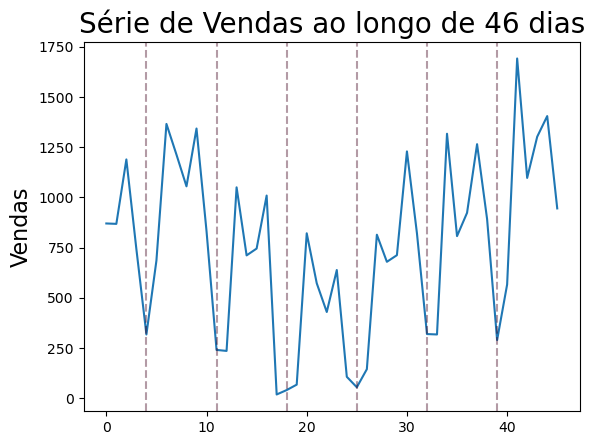

In [4]:
#observando a série temporal
plt.plot(dados['Vendas'])
for i in range(4,46,7):
    plt.axvline(i, color='#420420', linestyle='--',alpha=0.4)
plt.title("Série de Vendas ao longo de 46 dias", fontsize=20)
plt.ylabel("Vendas", fontsize=16)
plt.show()

- A série aparenta, visualmente,apresentar uma leve tendência. 

- Apresenta uma clara sazonalidade semanal, dado que os picos e vales se distribuem 7 vezes, consecutivamente (mesmo número de semanas do período).

In [5]:
#importando o conjunto de dados como série
path_file = r'C:\Users\X\Downloads\Projetos\DesafioFrexco\Dados.xlsx'
dados = pd.read_excel(path_file, index_col='Data',parse_dates=True).asfreq('D')
dados.head() #conferindo a importação

,Vendas
Data,
2022-12-06,870
2022-12-07,868
2022-12-08,1189
2022-12-09,742
2022-12-10,317


<a id="4.1"></a>
# **<center><span style="color:#0A75AD;">4.1 Modelo ajustado sem auto-sarima </span></center>**

**Usarei, primeiramente, um modelo ajustado "a mão" pelo SARIMAX sem covariáveis exógenas.**

In [6]:
#ADH
X = dados
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.507607
p-value: 0.529745
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609


- O teste não rejeita H0. Portanto, a série não é estacionária.

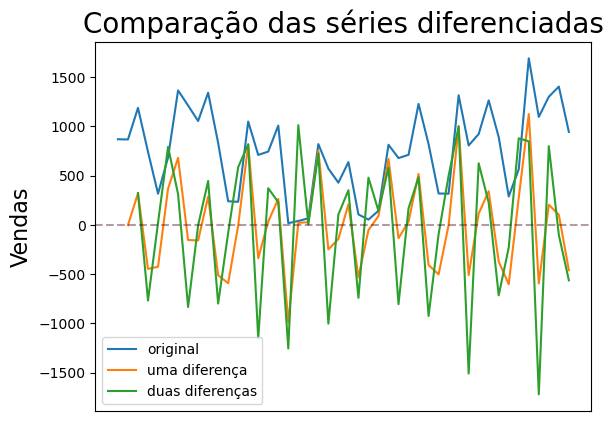

In [7]:
# tomando as diferenças
diff = X.diff()
diff2 = diff.diff()
plt.plot(X)
plt.plot(diff)
plt.plot(diff2)
plt.axhline(0, color='#420420', linestyle='--',alpha=0.4)
plt.title("Comparação das séries diferenciadas", fontsize=20)
plt.ylabel("Vendas", fontsize=16)
plt.xticks([], [])
plt.legend(['original','uma diferença','duas diferenças'])
plt.show()

- Acima, podemos ver que a série se torna mais estacionária tomando-se as diferenças.

In [8]:
#ADH série diferenciada
## diferenciada 1 vez
result = adfuller(diff[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

## diferenciada 2 vezes
result = adfuller(diff2[2:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.174417
p-value: 0.215661
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609
ADF Statistic: -6.249244
p-value: 0.000000
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


- O teste rejeita H0 quando tomamos duas diferenças. Portanto, a série se torna estacionária.

# **<center><span style="color:#0A75AD;">Usando ACF/PACF na série para encontrar os lags AR e MA</span></center>**

In [9]:
#separando dados com duas diferencas para ACF/PACF
treino = diff2[2:42]

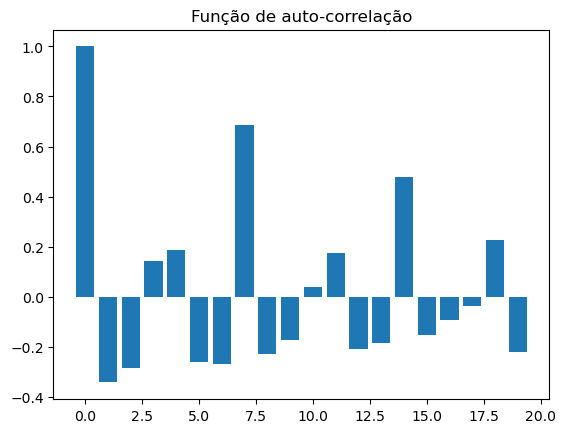

In [10]:
#ACF
acf_vals = acf(treino,nlags=20)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.title('Função de auto-correlação')
plt.show()

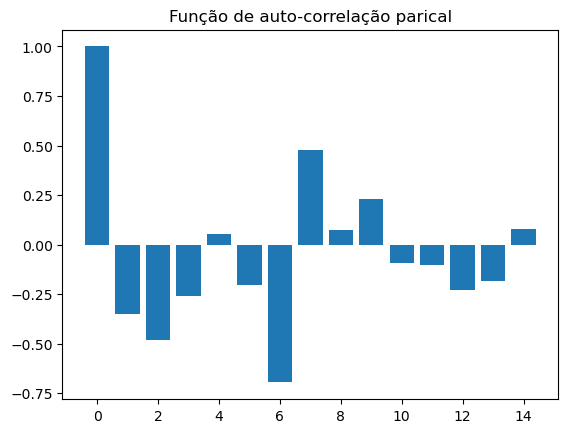

In [11]:
#PCF
pacf_vals = pacf(treino)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.title('Função de auto-correlação parical')
plt.show()

- Ambas as funções deram significantes no lag 7, podemos ajustar pela parte auto-regressiva ou de médias móveis.
- Optei por ajustar pela parte de RA, acabou sendo um ajuste parecido com o do auto-sarima. Porém com uma diferença a menos.

In [12]:
#conjunto de treino e de teste
treino = X[:42]
teste = X[42:]

#construindo o modelo SARIMA(0,0,1)(0,2,0)7
modelo = SARIMAX(treino.Vendas,order=(0,0,1),seasonal_order=(0,2,0,7))

In [13]:
#ajustando o modelo
modelo_ajustado = modelo.fit()
print(modelo_ajustado.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Vendas   No. Observations:                   42
Model:             SARIMAX(0, 0, 1)x(0, 2, [], 7)   Log Likelihood                -205.996
Date:                            Wed, 01 Feb 2023   AIC                            415.992
Time:                                    12:49:27   BIC                            418.656
Sample:                                12-06-2022   HQIC                           416.806
                                     - 01-16-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5925      0.205      2.887      0.004       0.190       0.995
sigma2      1.445e+05   4.66e+04   

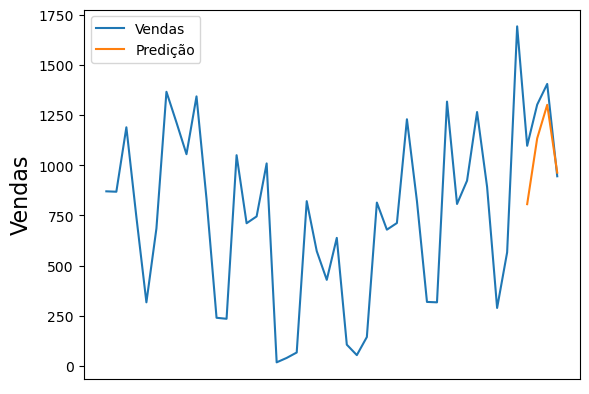

In [14]:
#predicoes do modelo
predictions = modelo_ajustado.predict(len(treino),len(dados))
predictions = pd.Series(predictions, index=teste.index)
teste = pd.Series(teste.Vendas, index=teste.index)#transformando no mesmo objeto para comparar
plt.plot(dados)
plt.plot(predictions)
plt.ylabel("Vendas", fontsize=16)
plt.xticks([], [])
plt.legend(['Vendas','Predição'])
plt.show()

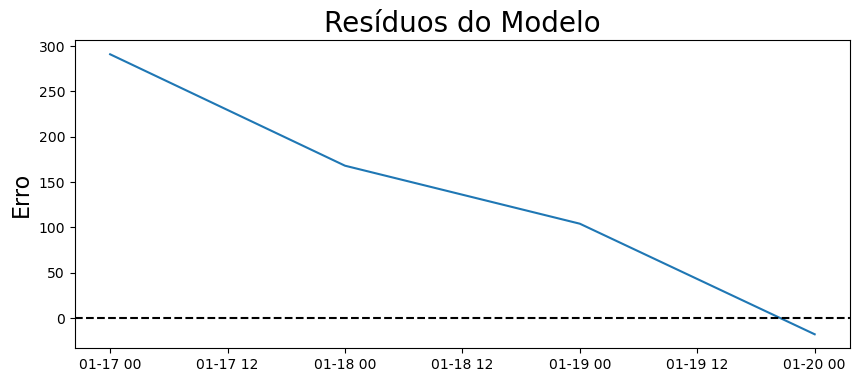

In [15]:
#residuos do modelo
residuals = teste - predictions
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Resíduos do Modelo', fontsize=20)
plt.ylabel('Erro', fontsize=16)
plt.show()

- **Considerações:**
- Tanto pelas predições quanto pelos resíduos, podemos ver o que o modelo subestima o valor real.

<a href="#toc" role="button" aria-pressed="true" >⬆️De volta aos tópicos ⬆️</a>

<a id="4.2"></a>
# **<center><span style="color:#0A75AD;">4.2 Modelo ajustado com auto-sarima </span></center>**

**Usarei agora o auto-arima com a parte sazonal definida como 7, escolha dada as observações já feitas previamente.**

In [16]:
#autoarima
modelo = auto_arima(y=treino.Vendas,m=7)
modelo

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 7),
      suppress_warnings=True, with_intercept=False)

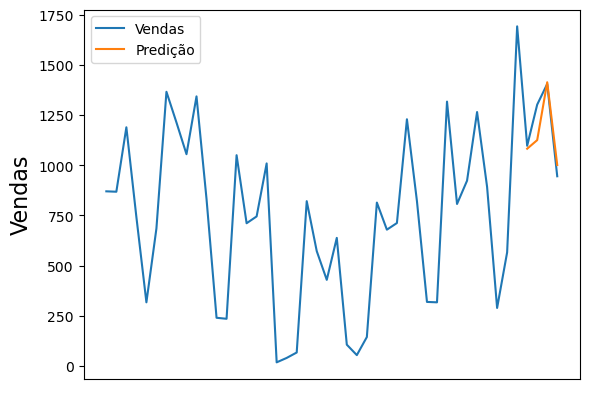

In [17]:
#predicoes do modelo
predicoes = pd.Series(modelo.predict(len(teste)))
predicoes.index = teste.index
plt.plot(dados)
plt.plot(predicoes)
plt.ylabel("Vendas", fontsize=16)
plt.xticks([], [])
plt.legend(['Vendas','Predição'])
plt.show()

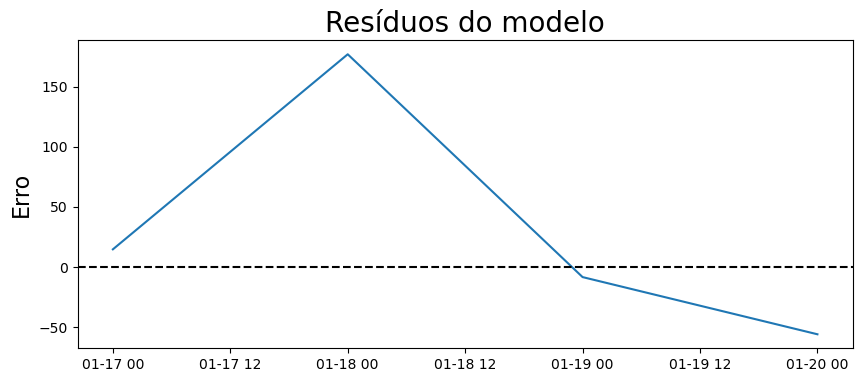

In [18]:
#residuos do modelo
residuos = teste - predicoes
plt.figure(figsize=(10,4))
plt.plot(residuos)
plt.axhline(0, linestyle='--', color='k')
plt.title('Resíduos do modelo', fontsize=20)
plt.ylabel('Erro', fontsize=16)
plt.show()

- **Considerações:**
- Tanto pelas predições quanto pelos resíduos, podemos ver o que o modelo se ajustou bem ao valor real.

<a href="#toc" role="button" aria-pressed="true" >⬆️De volta aos tópicos ⬆️</a>

<a id="4.3"></a>
# **<center><span style="color:#0A75AD;">4.3 Modelo ajustado de forma própria</span></center>**

**Esse modelo foi feito de forma experimental por mim.**
- Considero a sazonalidade de 7 dias para criar uma média de demanda da semana posterior.
- Esse modelo assume homocedasticidade, assim como a estacionaridade da média.

In [19]:
#achando os dias da semana
X['dia'] = X.index.dayofweek
treino = X[:42]

#groupby em dias da semana
diass = treino.groupby('dia', as_index=False).agg({'Vendas':'mean'})
previs = pd.Series(diass[(diass['dia']>=1) & (diass['dia']<=4)].loc[:,'Vendas'])
previs.index = teste.index

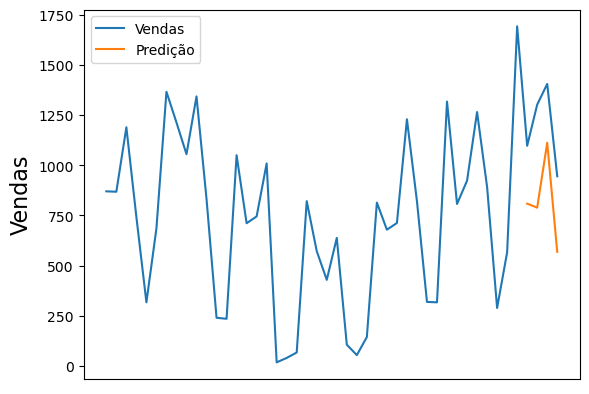

In [20]:
dados = dados.drop('dia', axis=1)#removendo dia da semana
#predicoes do modelo
plt.plot(dados)
plt.plot(previs)
plt.ylabel("Vendas", fontsize=16)
plt.xticks([], [])
plt.legend(['Vendas','Predição'])
plt.show()

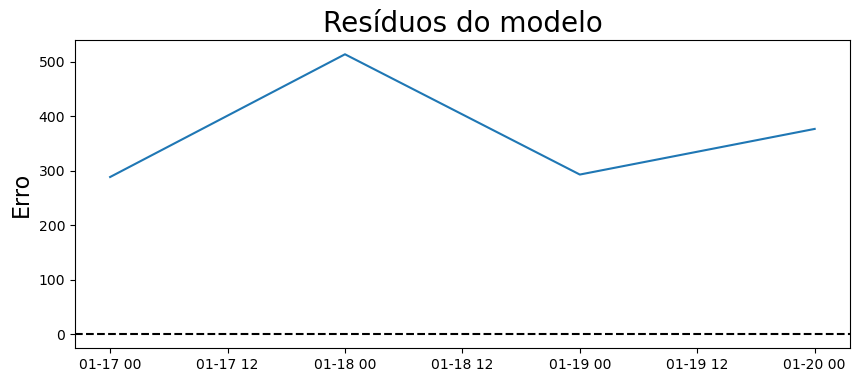

In [21]:
#residuos do modelo
resids = teste - previs
plt.figure(figsize=(10,4))
plt.plot(resids)
plt.axhline(0, linestyle='--', color='k')
plt.title('Resíduos do modelo', fontsize=20)
plt.ylabel('Erro', fontsize=16)
plt.show()

**Considerações:**
- Tanto pelas predições quanto pelos resíduos, podemos ver o que o modelo se ajustou muito mal ao valor real.
- Era o esperado devido as restrições supostas, mas queria testá-lo do mesmo jeito.

<a href="#toc" role="button" aria-pressed="true" >⬆️De volta aos tópicos ⬆️</a>

<a id="5"></a>
# **<center><span style="color:#386E6B;">5. Métricas/escolha e previões pedidas </span></center>**

# **<center><span style="color:#0A75AD;">Métrica e escolha do modelo</span></center>**

**Escolha de métrica:**
- Uma métrica comumente usada e que faz total sentino no contexto desse problema preditivo é o EQM. Portanto, ela séra usada para escolha do melhor modelo.

In [22]:
#EQM de cada modelo prosposto
a=np.sqrt(sum(np.array(residuals)**2))/4
b=np.sqrt(sum(np.array(residuos)**2))/4
c=np.sqrt(sum(np.array(resids)**2))/4

print('EQM: ')
print('SARIMA: %f' % a)
print('AUTO-SARIMA: %f' % b)
print('PRÓPIO: %f' % c)

EQM: 
SARIMA: 88.037073
AUTO-SARIMA: 46.569888
PRÓPIO: 189.431853


- O modelo com melhor desempenho segundo o critério de 'Erro quadrático médio'  foi o ajustado pelo auto-sarima. Portanto, ele será a minha escolha final.

In [23]:
#construindo o modelo SARIMA(1,0,0)(0,1,0)7
modelo = SARIMAX(dados.Vendas,order=(1,0,0),seasonal_order=(0,1,0,7))

In [24]:
#ajustando o modelo
modelo_ajustado = modelo.fit()
print(modelo_ajustado.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Vendas   No. Observations:                   46
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 7)   Log Likelihood                -264.327
Date:                           Wed, 01 Feb 2023   AIC                            532.653
Time:                                   12:49:32   BIC                            535.980
Sample:                               12-06-2022   HQIC                           533.847
                                    - 01-20-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7344      0.086      8.496      0.000       0.565       0.904
sigma2      4.505e+04   9997.492      4.506

# **<center><span style="color:#0A75AD;">Previsões pedidas</span></center>**

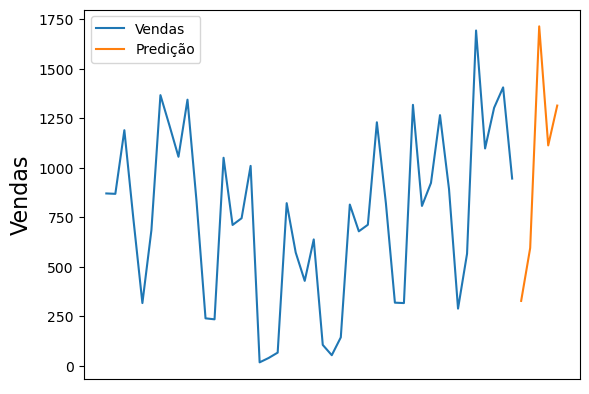

In [25]:
#datas
date1 = '2023-01-21'
date2 = '2023-01-25'
dataspred = pd.date_range(date1, date2).tolist()

#predicoes do modelo
predicoes = modelo_ajustado.predict(len(dados),len(dados)+5)
predicoes = pd.Series(predicoes, index=dataspred)
plt.plot(dados)
plt.plot(predicoes)
plt.ylabel("Vendas", fontsize=16)
plt.xticks([], [])
plt.legend(['Vendas','Predição'])
plt.show()

In [26]:
print(round(predicoes))

2023-01-21     328.0
2023-01-22     595.0
2023-01-23    1713.0
2023-01-24    1112.0
2023-01-25    1313.0
Name: predicted_mean, dtype: float64


**Acima, podemos ver tanto o comportamento gráfico quanto os valores das predições do dia 21/01/2023 até o dia 25/01/2023 das vendas do item.**
<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    🎯 &nbsp;<b><u>Predições :</u></b><br>
* <i> O número de vendas, segundo o modelo, em <b><u>2023-01-21  (Sábado)</u></b> seria <b><u>328</u></b></i><br>
* <i> O número de vendas, segundo o modelo, em <b><u>2023-01-22  (Domingo)</u></b> seria <b><u>595</u></b></i><br>
* <i> O número de vendas, segundo o modelo, em <b><u>2023-01-23  (Segunda)</u></b> seria <b><u>1.713</u></b></i><br>
* <i> O número de vendas, segundo o modelo, em <b><u>2023-01-24  (Terça)</u></b> seria <b><u>1.112</u></b></i><br>
* <i> O número de vendas, segundo o modelo, em <b><u>2023-01-25  (Quarta)</u></b> seria <b><u>1.313</u></b></i><br>
</div>

# **<center><span style="color:#0A75AD;">Mensagem final</span></center>**

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    
    
### <center>Obrigado pela leitura e a oportunidade de participar do desafio🙂</center>
### <center>Isso foi tudo 👋</center>

<a href="#toc" role="button" aria-pressed="true" >⬆️De volta aos tópicos ⬆️</a>